In [163]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

%matplotlib inline  
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import time
from sklearn.model_selection import train_test_split

In [164]:
from sklearn.datasets import load_boston
bdata = load_boston()


In [165]:
print ("keys:", bdata.keys())
print ("feature names:",  bdata.feature_names)
print ("data shape:", bdata.data.shape)
print ("target shape", bdata.target.shape)
# print (bdata.DESCR)
print ("-"*80)


keys: dict_keys(['DESCR', 'feature_names', 'data', 'target'])
feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
data shape: (506, 13)
target shape (506,)
--------------------------------------------------------------------------------


In [166]:
# Creating a matrix consisting of the features and target variable
bdata_full = np.insert(bdata.data, bdata.data.shape[1], bdata.target, axis = 1)

In [167]:
# Data Frame for running the linear regression
bdata_df = pd.DataFrame(bdata.data, columns = bdata.feature_names)
bdata_df['MEDV'] = pd.Series(bdata.target, index=bdata_df.index)

In [168]:
# Running Linear Regression
lin_reg = LinearRegression()
# Fitting the model
lin_reg.fit(bdata_full[:,5:6], bdata_full[:,13:14])

print('Intercept:', lin_reg.intercept_)
print('Coefficient:', lin_reg.coef_)
print('Coefficient of determination: %.2f' %lin_reg.score(bdata_full[:,5:6], bdata_full[:,13:14]))

Intercept: [-34.67062078]
Coefficient: [[ 9.10210898]]
Coefficient of determination: 0.48


Interpretation:

From the above linear regression, we see that as the number of rooms per house increases by 1, the Median price for the house may increase by 9.1021 or $9102 approximately. An R-squared value of 0.48 indicates that the model is only able to explain 48% of the variability in our data.

In [169]:
from sklearn.preprocessing import PolynomialFeatures
# Since we need a square term, I'm using degree = 2. Removing the bias term as we dont need this.
poly_reg = PolynomialFeatures(degree = 2,include_bias=False)
# X poly contains my dependent variable along with its squared value.
X_poly = poly_reg.fit_transform(bdata_full[:,5:6])
# Running linear regressions using the feature and its squared term
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, bdata_full[:,13:14])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [170]:
print('Intercept:', lin_reg_2.intercept_)
#Coefficient
print('Coefficient:', lin_reg_2.coef_)
# R-squared value
print('Coefficient of determination: %.2f' %lin_reg_2.score(X_poly, bdata_full[:,13:14]))

Intercept: [ 66.05884748]
Coefficient: [[-22.64326237   2.47012384]]
Coefficient of determination: 0.55


From the above linear regression, we see that as the number of rooms per house increases by 1, the Median price for the house may increase by 2.47 or $2470 approximately. An R-squared value of 0.55 indicates that the model is able to explain 55% of the variability in our data. Since we used a polynomial term in the model, we used the coefficient of the polynomial term to interpret the result. We see this model does a better job at explaining the variability in our data compared to the previous model.

### 1.2 Training and testing

In [171]:
kf = KFold(n_splits = 250, random_state=1, shuffle=False)
slope = []
intercept = []
for i, j in kf.split(bdata_full):
    df_train, df_test = bdata_full[i], bdata_full[j]
    lm_kfold = LinearRegression().fit(df_train[:,5:6], df_train[:,13:14])
    intercept.append(float(lm_kfold.intercept_))
    slope.append(float(lm_kfold.coef_))  

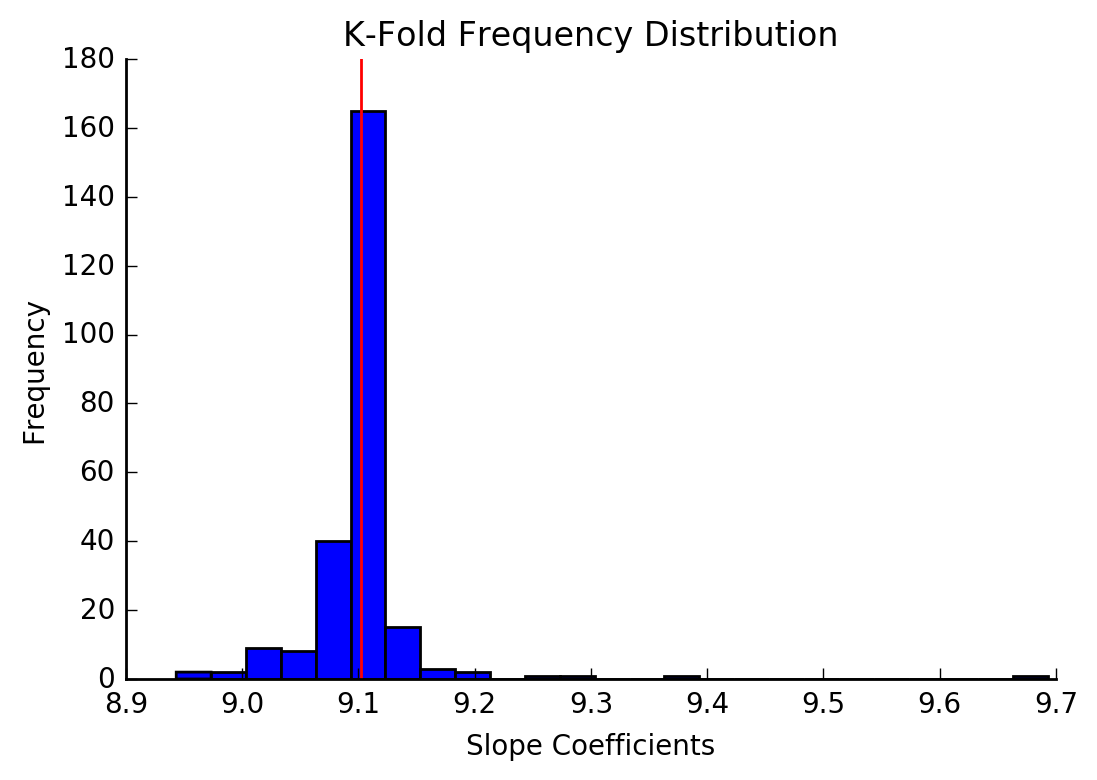

In [172]:
plt.figure()
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks
ax = plt.hist(slope, bins= 25, color = 'Blue')
plt.axvline(lin_reg.coef_, color = 'red')
plt.xlabel('Slope Coefficients')
plt.ylabel('Frequency')
plt.title('K-Fold Frequency Distribution')

From the above plot, we see that the coefficient terms are almost normally distributed with its mean value around the coefficient result from question 1.1 . This comes from the central limit theorem. Irrespective of if the data is normally distributed, the beta coefficients of a regression always have the property of asymptotic normal distribution.

### 1.3 Regression lines

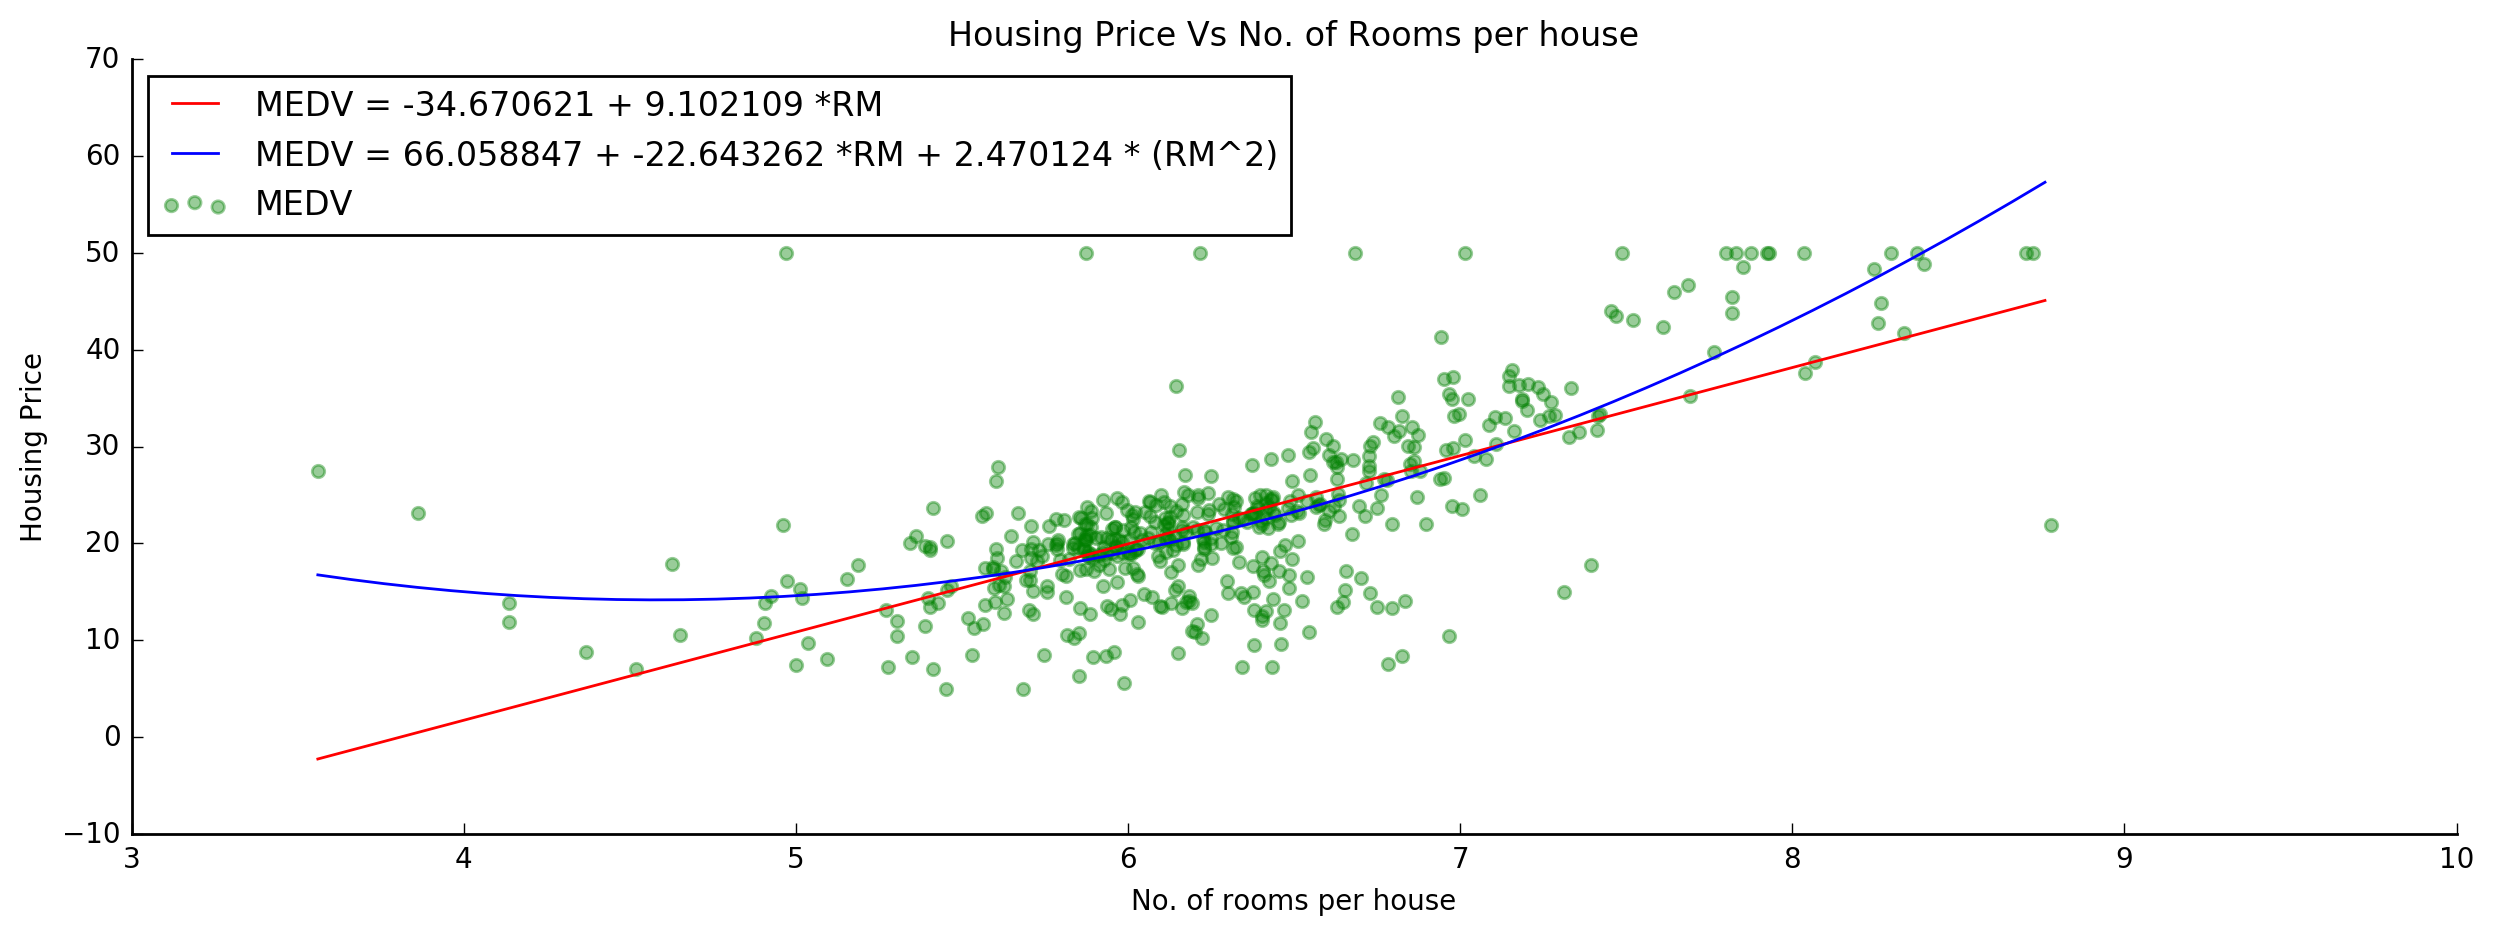

In [173]:
plt.figure(figsize=(15,5))
ax = plt.axes()
ax.spines['right'].set_color('none') # Remove right axis
ax.spines['top'].set_color('none') # Remove top axis
ax.get_xaxis().tick_bottom() # Remove top ticks
ax.get_yaxis().tick_left() # Remove right ticks
# Visualising the Polynomial Regression results (for higher resolution and smoother curve)
X_grid = np.arange(min(bdata_full[:,5:6]), max(bdata_full[:,5:6]), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(bdata_full[:,5:6], bdata_full[:,13:14], color = 'green',alpha = 0.4,label = 'MEDV')
# plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue')
plt.plot(X_grid, lin_reg.predict(X_grid), color = 'red',label= ('MEDV = %f + %f *RM' %(lin_reg.intercept_,lin_reg.coef_)))
plt.plot(X_grid, lin_reg_2.predict(poly_reg.fit_transform(X_grid)), color = 'blue', label = ('MEDV = %f + %f *RM + %f * (RM^2)' %(lin_reg_2.intercept_,lin_reg_2.coef_[:,0],lin_reg_2.coef_[:,1])))
plt.title('Housing Price Vs No. of Rooms per house')
plt.xlabel('No. of rooms per house')
plt.ylabel('Housing Price')
plt.legend(loc='upper left')

## Part 2: Gradient descent: Linear Regression

This is where it gets fun!

### 2.1 Implement gradient descent with one independent variable (Average rooms per house)

In [174]:
"""
    Function
    --------
    bivariate_ols: Gradient Decent to minimize OLS. Used to find coefficients of bivariate OLS Linear regression

    Parameters
    ----------
    xvalues, yvalues : narray xvalues: independent variable; yvalues: dependent variable
    R: float, Learning rate
    MaxIterations: Int, maximum number of iterations

    Returns
    -------
    alpha: float, intercept
    beta: float, co-efficient
    ttaken: time taken
    it: number of iterations
    convergence: logical, convergence achieved?
"""

def bivariate_ols(xvalues,yvalues, R, MaxIterations):
    # Recording start time
    start_time = time.time()
    xtrans = xvalues.transpose()
    m = xvalues.shape[0]
    # Initializing beta values to 0
    beta = np.zeros(xvalues.shape[1])
    # Initialization variables for comparisions to implement stop condition. This will be updated at the end of every loop.
    beta_init = beta[1]
    cost_init = 0
    alpha_init = beta[0]
    epsilon = 0.0001
    for iter in range(0,MaxIterations):
        # Calculate hypothesis function
        hypothesis = np.dot(xvalues, beta)
        # Calculate loss function
        loss = (hypothesis - yvalues)
        # Calculate cost function
        cost = np.sum(loss**2)/(2*m)
        # Calculate gradient
        gradient = np.dot(xtrans,loss)/m
        # Update beta
        beta = beta - R*gradient
        # Stopping condition
        if (abs(beta_init - beta[1]) < epsilon and abs(alpha_init - beta[0]) < epsilon and abs(cost_init - cost) < epsilon):
            elapsed_time = time.time() - start_time
            return alpha_init,beta_init,iter-1,elapsed_time,True
            break
        # If stop conditions not met, update the initialization variables and continue the loop
        beta_init = beta[1]
        alpha_init = beta[0]
        cost_init = cost
    # Record algorithm run time
    elapsed_time = time.time() - start_time
    return(beta[0], beta[1], elapsed_time, iter, False)    

In [175]:
# Create X matrix with 1's appended to 1st column for calculation of alpha value
xvalues = np.hstack((np.ones(bdata_full.shape[0])[:, np.newaxis], bdata_full[:,5:6]))
yvalues = bdata_full[:,13]
MaxIterations = 50000

In [177]:
# Test convergence for various learning rates
R = [0.01,0.001,0.1,0.03,0.04]
for i in R:
    alpha, beta, it, ttaken , convergence = bivariate_ols(xvalues, yvalues, i, MaxIterations)
    if convergence == True:
        print("Learning rate:",i)
        print("Value of alpha that minimizes the loss function is: ",alpha)
        print("Value of beta that minimizes the loss function is: ",beta)
        print("The algorithm took %i iterations to converge" %it)
        print("The time taken by the algorithm to run is:",ttaken,"Seconds\n")
    else:
        print("Learning rate:",i)
        print("The algorithm failed to converge \n")

Learning rate: 0.01
Value of alpha that minimizes the loss function is:  -33.8390012284
Value of beta that minimizes the loss function is:  8.97137417217
The algorithm took 31155 iterations to converge
The time taken by the algorithm to run is: 0.6985561847686768 Seconds

Learning rate: 0.001
The algorithm failed to converge 

Learning rate: 0.1
The algorithm failed to converge 

Learning rate: 0.03
Value of alpha that minimizes the loss function is:  -34.393389988
Value of beta that minimizes the loss function is:  9.05852689576
The algorithm took 13428 iterations to converge
The time taken by the algorithm to run is: 0.3318150043487549 Seconds

Learning rate: 0.04
Value of alpha that minimizes the loss function is:  -34.4627815809
Value of beta that minimizes the loss function is:  9.06943560595
The algorithm took 10669 iterations to converge
The time taken by the algorithm to run is: 0.26787900924682617 Seconds



We see my algorithm doesn't converge for R = 0.001 and 0.1 within the set 50000 iteration.
Increasing the epochs from 50000 to a higher value may lead it to converge.
I'm leave it as is, so that we can see if these converge within 50000 epochs after standardization.

### 2.2 Data normalization

Soon, we will implement a version of gradient descent that can use an arbitrary number of independent variables. Before doing this, we want to give you some code in case you want to standardize your features.

In [134]:
def standardize(raw_data):
    """
    standardizes raw data and returns
    standardized data, mean by column, sd by column
    """
    mu = np.mean(raw_data, axis = 0)
    sd = np.std(raw_data, axis = 0)
    return (raw_data - mu) / sd, mu, sd

### 2.3 Gradient descent with an arbitrary number of independent variables

Now that we have a simple version of gradient descent working,we will create a version of gradient descent that can take more than one independent variable.  Assume all independent variables will be continuous.

In [135]:
"""
Function
--------
multiple_ols
    Gradient Decent to minimize OLS. Used to find co-efficients of bivariate OLS Linear regression

Parameters
----------
xvalue_matrix, yvalues : narray
    xvalue_matrix: independent variable
    yvalues: dependent variable
    
R: float
    Learning rate
    
MaxIterations: Int
    maximum number of iterations

Returns
-------
beta: array[float], coefficients
"""
def multiple_ols(xvalues_matrix,yvalues, R, MaxIterations):
    # Record start time
    start_time = time.time()
    xtrans = xvalues_matrix.transpose()
    # Find number of rows in our data and store it in a variable
    m = xvalues_matrix.shape[0]
    # Initialize number of betas according to the number of features in our input X matrix
    beta = np.zeros(xvalues_matrix.shape[1])
    # Init variables for implementing stop condition. Will be updated at the end of every loop.
    beta_init = beta[1:]
    cost_init = 0
    alpha_init = beta[0]
    epsilon = 0.0001
    for iter in range(0,MaxIterations):
        # Calculate hypothesis function
        hypothesis = np.dot(xvalues_matrix, beta)
        # Calculate loss
        loss = (hypothesis - yvalues)
        # Calculate cost descent
        cost = np.sum(loss**2)/(2*m)
        # Calculate gradient descent
        gradient = np.dot(xtrans,loss)/m
        # Update Beta
        beta = beta - R*gradient
        # Implement stopping condition
        if (np.around(abs(beta_init - beta[1:]),decimals=4).all() < epsilon 
            and np.around(abs(alpha_init - beta[0]),decimals=4) < epsilon and np.around(abs(cost_init - cost),decimals=4) < epsilon):
            elapsed_time = time.time() - start_time
            return alpha_init,beta_init,iter-1,elapsed_time,True
        # If stopping condition not met, update our init variables for comparision during next iteration.
        else:
            beta_init = beta[1:]
            alpha_init = beta[0]
            cost_init = cost
    elapsed_time = time.time() - start_time
    return(beta[0], beta[1], elapsed_time, iter, False)    

In [136]:
# Generate feature matrix
xvalues_matrix = bdata_full[:, (0,5)]
# Dependent variable array
yvalues = bdata_full[:,13]
MaxIterations = 50000
# Standardize the data
norm_x, mu_x, sd_x = standardize(xvalues_matrix)
# Add column of 1's for alpha value calculation
xvalues_norm = np.hstack((np.ones(bdata_full.shape[0])[:, np.newaxis], norm_x))

In [137]:
R = [0.1,0.01,0.001]
for i in R:
    alpha, beta, it, ttaken , convergence = multiple_ols(xvalues_norm, yvalues, i, MaxIterations)
    if convergence == True:
        print("Learning rate:",i)
        print("Value of alpha that minimizes the loss function is: ",alpha)
        print("Value of beta1 that minimizes the loss function is: ",beta[0])
        print("Value of beta2 that minimizes the loss function is: ",beta[1])
        print("The algorithm took %i iterations to converge" %it)
        print("The time taken by the algorithm to run is:",ttaken,"Seconds\n")
    else:
        print("Learning rate:",i)
        print("The algorithm failed to converge \n")

Learning rate: 0.1
Value of alpha that minimizes the loss function is:  22.5323215368
Value of beta1 that minimizes the loss function is:  -2.24906252843
Value of beta2 that minimizes the loss function is:  5.89394925742
The algorithm took 101 iterations to converge
The time taken by the algorithm to run is: 0.00488591194152832 Seconds

Learning rate: 0.01
Value of alpha that minimizes the loss function is:  22.5278505859
Value of beta1 that minimizes the loss function is:  -2.25104488307
Value of beta2 that minimizes the loss function is:  5.89170320198
The algorithm took 837 iterations to converge
The time taken by the algorithm to run is: 0.048748016357421875 Seconds

Learning rate: 0.001
Value of alpha that minimizes the loss function is:  22.4828238939
Value of beta1 that minimizes the loss function is:  -2.26176956832
Value of beta2 that minimizes the loss function is:  5.87654961453
The algorithm took 6107 iterations to converge
The time taken by the algorithm to run is: 0.23206

### 2.4 Compare standardized vs. non-standardized results

Repeat the analysis from 2.3, but this time we do not standardize your variables - i.e., use the original data. 

In [138]:
xvalues_matrix = bdata_full[:, (0,5)]
yvalues = bdata_full[:,13]
MaxIterations = 50000
xvalues = np.hstack((np.ones(bdata_full.shape[0])[:, np.newaxis], xvalues_matrix))

In [139]:
R = [0.1,0.01,0.001]
for i in R:
    alpha, beta, it, ttaken , convergence = multiple_ols(xvalues, yvalues, i, MaxIterations)
    if convergence == True:
        print("Learning rate:",i)
        print("Value of alpha that minimizes the loss function is: ",alpha)
        print("Value of beta1 that minimizes the loss function is: ",beta[0])
        print("Value of beta2 that minimizes the loss function is: ",beta[1])
        print("The algorithm took %i iterations to converge" %it)
        print("The time taken by the algorithm to run is:",ttaken,"Seconds\n")
    else:
        print("Learning rate:",i)
        print("The algorithm failed to converge \n")

Learning rate: 0.1
The algorithm failed to converge 

Learning rate: 0.01
Value of alpha that minimizes the loss function is:  -28.8553867755
Value of beta1 that minimizes the loss function is:  -0.26331362988
Value of beta2 that minimizes the loss function is:  8.32816611748
The algorithm took 37523 iterations to converge
The time taken by the algorithm to run is: 2.63034987449646 Seconds

Learning rate: 0.001
The algorithm failed to converge 



From the above results we see that the algoritm failed for converge for R values of 0.1 and 0.001 within the set 50000 iteration limit. This wasn't the case when we standardized the data , where both of these cases converged in 101 and 6107 iterations respectively.

Also, for R= 0.01, the non-standardized version took 37523 iterations to converge and took 1.31 seconds to run. The same case with standardized features took only 837 iterations to converge and 0.06 seconds to run.

Hence, clearly standardizing features allow the algorithm to run faster by making it easier for the algorithm to converge faster.

## 3. Prediction

Let's use our fitted model to make predictions about housing prices. Since the focus is now on prediction rather than the interpretation of the coefficients,we will first standardize your features before proceeding.

### 3.1 Cross-Validation

In [140]:
# Divide our data into training (66%) and test set (34%)
X_train, X_test, y_train, y_test = train_test_split(bdata_full[:,(0,5)], bdata_full[:,13], test_size = 0.34, random_state = 1)

In [141]:
MaxIterations = 50000
# Standardize the training set
norm_x_train, mu_x_train, sd_x_train = standardize(X_train)
# Standardize the test set
norm_x_test, mu_x_test, sd_x_test = standardize(X_test)
# Append 1's column for alpha calculation
xvalues_norm_train = np.hstack((np.ones(norm_x_train.shape[0])[:, np.newaxis], norm_x_train))
R = 0.1

In [142]:
# Running gradient descent on standardized X training .We dont standardize our Y.
alpha_train, beta_train, it_train, ttaken_train , convergence_train = multiple_ols(xvalues_norm_train, y_train, R, MaxIterations)
print("Learning rate:",R)
print("Value of alpha that minimizes the loss function is: ",alpha_train)
print("Value of beta1 that minimizes the loss function is: ",beta_train[0])
print("Value of beta2 that minimizes the loss function is: ",beta_train[1])
print("The algorithm took %i iterations to converge" %it_train)
print("The time taken by the algorithm to run is:",ttaken_train,"Seconds\n")

Learning rate: 0.1
Value of alpha that minimizes the loss function is:  22.3561058124
Value of beta1 that minimizes the loss function is:  -2.07973740919
Value of beta2 that minimizes the loss function is:  5.68520769207
The algorithm took 104 iterations to converge
The time taken by the algorithm to run is: 0.004909038543701172 Seconds



### 3.2 Predicted values and RMSE

Let's figure out how accurate this predictive model turned out to be. We will compute the RMSE on our test cases, i.e. take the model parameters that we found above and compare the actual to the predicted values for just the test instances.

Using Variables CRIM and RM

In [143]:
# Predict Y-values
y_predicted = alpha_train + np.dot(norm_x_test,beta_train)

In [144]:
# Function to compute rmse. Pulled from the last assignment
def compute_rmse(predictions, yvalues):
    squared = (np.asarray(predictions) - np.asarray(yvalues)) **2
    root_ms = np.sqrt(squared.sum()/len(predictions))
    return root_ms

In [145]:
# Compute RMSE values
rmse = compute_rmse(y_predicted, y_test)
print("RMSE using 2 feature CRIM and RM:",rmse)

RMSE using 2 feature CRIM and RM: 6.06747584159


Using Variable RM only

In [146]:
MaxIterations = 50000
norm_x_train1, mu_x_train1, sd_x_train1 = standardize(X_train[:,1:2])
norm_x_test1, mu_x_test1, sd_x_test1 = standardize(X_test[:,1:2])
xvalues_norm_train1 = np.hstack((np.ones(norm_x_train1.shape[0])[:, np.newaxis], norm_x_train1))
xvalues_norm_test1 = np.hstack((np.ones(norm_x_test1.shape[0])[:, np.newaxis], norm_x_test1))
R = 0.1

In [147]:
alpha_train1, beta_train1, it_train1, ttaken_train1 , convergence_train1 = multiple_ols(xvalues_norm_train1, y_train, R, MaxIterations)

In [148]:
y_predicted1 = alpha_train1 + np.dot(norm_x_test1,beta_train1)
rmse1 = compute_rmse(y_predicted1, y_test)
print("RMSE using 1 feature RM:",rmse1)

RMSE using 1 feature RM: 6.53904166463


We see using 1 feature "RM" only , we get a RMSE of 6.53.
Using 2 features "RM" and "CRIM" , our RMSE reduced to 6.06. 
Hence, adding the additional feature improved our model slightly.

Using nearest neighbour algorithm on standardized "CRIM and RM" features resulted in an RMSE of 7.73. Clearly, the linear model using gradient descent resulted in a better model with a lower RMSE of 6.06!
Also, the algorithm is substantially faster in this case.

## 4 Regularization 

### 4.1 Get prepped

Step 1: We will create new interaction variables between each possible pair of the F_s features.  N
Step 2: For simplicity, we will generate a single training and testing set.

In [149]:
# Removing the dependent variable
bdata_features=bdata_full[:,:-1]
# Generating polynomial(interation) terms. Not including bias term, since we don't want to standardize it. We will add it manually later.
poly_reg_full = PolynomialFeatures(degree = 2,include_bias=False)
bdata_full_poly = poly_reg.fit_transform(bdata_features)

In [150]:
# Standardize the 104 features
full_poly_st, mu_poly_st, sd_poly_st = standardize(bdata_full_poly)

In [151]:
#Split to training and testing set
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(full_poly_st, bdata_full[:,13], test_size = 0.34, random_state = 0)

### 4.2 Let's overfit!
Now, using our version of multiple regression from 2.3, let's overfit the training data. Using our training set, we will regress housing price on as many of those K+(K*(K+1))/2 features as you can.  

In [152]:
MaxIterations = 50000
R = 0.1
# Append 1's column for alpha calculation
X_train_poly_bias = np.hstack((np.ones(X_train_poly.shape[0])[:, np.newaxis], X_train_poly))

In [153]:
# Running gradient descent ( Using 45 features to overfit!)
alpha_poly, beta_poly, it_poly, ttaken_poly , convergence_poly = multiple_ols(X_train_poly_bias[:,0:45], y_train_poly, R, MaxIterations)

In [154]:
# Predictions on training set
y_predicted_poly_train = alpha_poly + np.dot(X_train_poly[:,0:44],beta_poly)

In [155]:
# Predictions on the testing set
y_predicted_poly_test = alpha_poly + np.dot(X_test_poly[:,0:44],beta_poly)

In [156]:
rmse_poly_train = compute_rmse(y_predicted_poly_train, y_train_poly)
print("Root mean squared error from predictions on the Training set:",rmse_poly_train)

Root mean squared error from predictions on the Training set: 3.64996967071


In [157]:
rmse_poly_test = compute_rmse(y_predicted_poly_test, y_test_poly)
print("Root mean squared error from predictions on the Testing set:",rmse_poly_test)

Root mean squared error from predictions on the Testing set: 4.72944704484


From 3.2, we got an RMSE value of 6.06 on the training set and an RMSE value of 7.73 using KNN. 
We get a lower RMSE value of 4.72 in this case on the training set. While adding features does lead to reduction in the RMSE, this finding may be a bit misleading. We can rather improve our model from 3.2 by using feature selection methods instead. Because, using 44 features may be leading to overfitting. This can become more prominent when we have more number of observations in the testing set.

We also see that while we got an RMSE of 3.64 on the training set, indicating that our model fits the training set very well. We get a lesser fit on the testing set where we get an RMSE value of 4.72. This can become more prominent if we had more observations in our testing set.

Thus, we see that adding additional features for the sake of making our model more complex leads to overfitting.

### 4.3 Ridge regularization

In [158]:
def ridge_ols(xvalues_matrix,yvalues, R, MaxIterations,L):
    start_time = time.time()
    xtrans = xvalues_matrix.transpose()
    m = xvalues_matrix.shape[0]
    beta = np.zeros(xvalues_matrix.shape[1])
    beta_init = beta[1:]
    cost_init = 0
    alpha_init = beta[0]
    epsilon = 0.0001
    for iter in range(0,MaxIterations):
        hypothesis = np.dot(xvalues_matrix, beta)
        loss = (hypothesis - yvalues)
        cost = np.sum(loss**2)/(2*m) + L * np.dot(beta[1:].T, beta[1:])
        gradient = np.dot(xtrans,loss)/m
        # Calculating the penalty term. Here, L is the lambda.
        penalty_ridge = (L/m)*beta
        # Calculating the beta by incorporating the penalty term.
        beta = beta - R*(gradient + penalty_ridge)
        if (np.around(abs(beta_init - beta[1:]),decimals=4).all() < epsilon 
            and np.around(abs(alpha_init - beta[0]),decimals=4) < epsilon and np.around(abs(cost_init - cost),decimals=4) < epsilon):
            elapsed_time = time.time() - start_time
            return alpha_init,beta_init,iter-1,elapsed_time,True
        else:
            beta_init = beta[1:]
            alpha_init = beta[0]
            cost_init = cost
    elapsed_time = time.time() - start_time
    return(beta[0], beta[1], elapsed_time, iter, False) 

In [159]:
MaxIterations = 50000
# R = 0.1
X_train_poly_bias = np.hstack((np.ones(X_train_poly.shape[0])[:, np.newaxis], X_train_poly))
alpha_poly, beta_poly, it_poly, ttaken_poly , convergence_poly = ridge_ols(X_train_poly_bias[:,0:45], y_train_poly, R, MaxIterations,0.5)

y_predicted_poly_train = alpha_poly + np.dot(X_train_poly[:,0:44],beta_poly)
rmse_poly_train = compute_rmse(y_predicted_poly_train, y_train_poly)
print("RMSE on the Training set after ridge regression:",rmse_poly_train)

y_predicted_poly = alpha_poly + np.dot(X_test_poly[:,0:44],beta_poly)
rmse_poly = compute_rmse(y_predicted_poly, y_test_poly)
print("RMSE on the Test set after ridge regression:",rmse_poly)

RMSE on the Training set after ridge regression: 3.6646329709
RMSE on the Test set after ridge regression: 4.70713959761


In [160]:
# For validation purpose, using SKLearn ridge regression to make predictions and calculate RMSE. I'm doing this to validate that my function
# for ridge regression is providing the expected results.
# This is not part of the question.

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
# Create linear regression object with a ridge coefficient 0.5
ridge = Ridge(fit_intercept=True, alpha=0.5)

# Train the model using the training set
ridge.fit(X_train_poly[:,0:44],y_train_poly)
p = ridge.predict(X_test_poly[:,0:44])
rmse_poly = compute_rmse(p, y_test_poly)
print("For verification only. Not part of the question")
print("RMSE on Test using SK Learn package:",rmse_poly)

For verification only. Not part of the question
RMSE on Test using SK Learn package: 4.7076372866


We see that now we get a training set RMSE of 3.66 and test set RMSE of 4.70. There is still substantial amount of overfitting here. This is expected since we are using 44 features!
However, if we compare these results from 4.2, we see that the RMSE on the training set has gone slightly higher and on the testing set it has reduced a bit. So, adding the penalty terms made the model fit the test set better, however it doesn't fit the training set as well as in 3.2. Thus, the penalty term compensates for adding features that don't improve the model and prevents overfitting to some extent.
While it is not very prominent here, I feel it will be usefull when we have more observations.

If we compare to KNN, we got an RMSE of 3.98 when we used forward selection to include useful features. If we used forward selection here as well, I feel we can get an even lower RMSE.
Hence, while Gradient descent / Linear regression performed better than KNN in general, feature selection is important and adding features randomly doesn't necessarily imporove the model.